# Coding Discussion 6
### Colette Yeager

In [1]:
# Import packages
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [21]:
# Import data
train = pd.read_csv("/Users/coletteyeager/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")
test = pd.read_csv("/Users/coletteyeager/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")

train.head(5)

,OBJECTID,SSL,BATHRM,HF_BATHRM,HEAT,HEAT_D,AC,NUM_UNITS,ROOMS,BEDRM,...,ROOF,ROOF_D,INTWALL,INTWALL_D,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,LN_PRICE
0,78021,4061N 0085,3.0,1.0,1.0,Forced Air,Y,1.0,9.0,4.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,11,2234,2018-07-22T18:01:43.000Z,13.591116
1,28783,1587 0075,2.0,1.0,7.0,Warm Cool,Y,1.0,7.0,3.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,3850,2018-07-22T18:01:43.000Z,12.730801
2,35035,2024 0817,2.0,2.0,13.0,Hot Water Rad,Y,1.0,9.0,4.0,...,11.0,Slate,6.0,Hardwood,1.0,1.0,12,7866,2018-07-22T18:01:43.000Z,13.651814
3,67983,3736 0059,1.0,1.0,7.0,Warm Cool,Y,1.0,6.0,3.0,...,2.0,Built Up,6.0,Hardwood,1.0,0.0,13,2739,2018-07-22T18:01:43.000Z,12.860999
4,8791,0817 0826,2.0,0.0,13.0,Hot Water Rad,N,1.0,11.0,4.0,...,6.0,Metal- Sms,6.0,Hardwood,1.0,0.0,11,2097,2018-07-22T18:01:43.000Z,14.100690


We're going to see how well the features related to house size predict the log selling price of a house in D.C. - BATHRM, BEDRM, GBA, and LANDAREA

## Explore the Data

<AxesSubplot:>

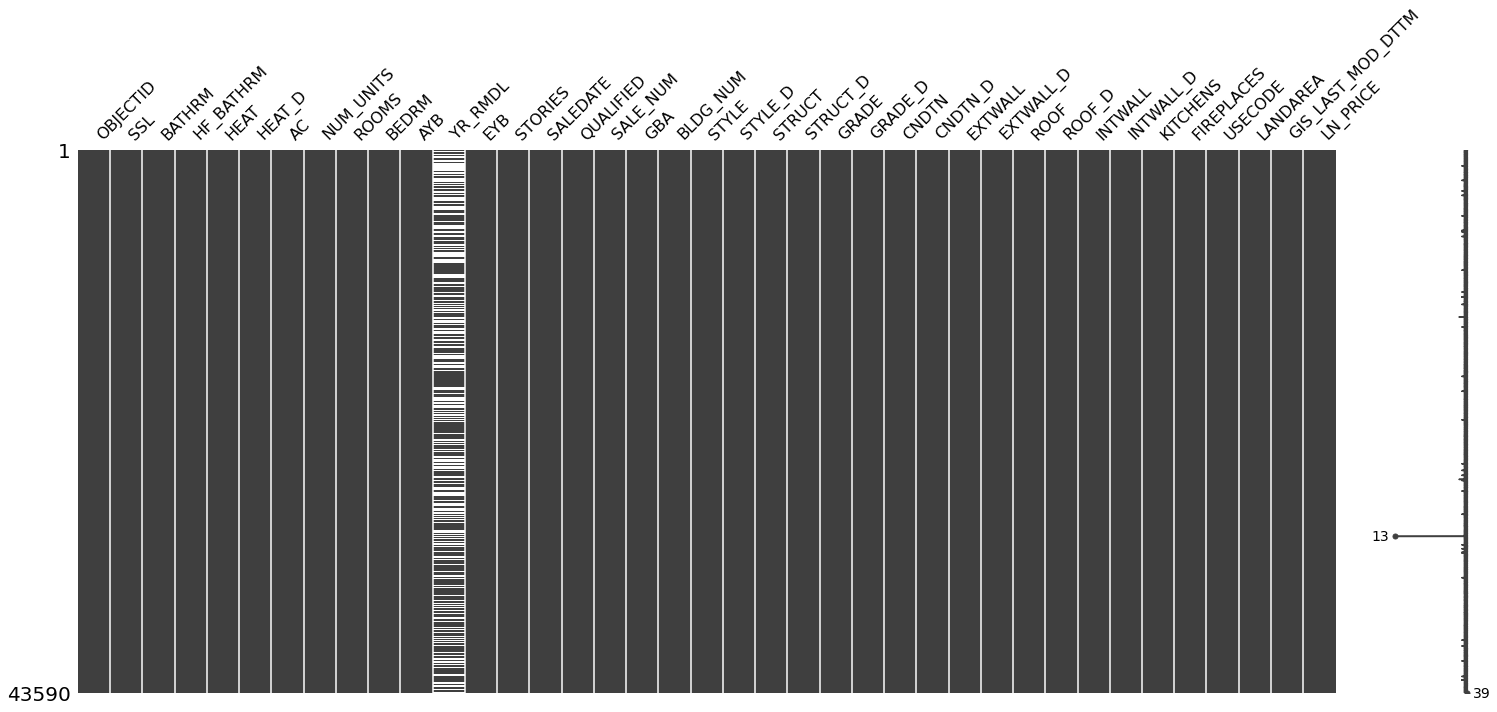

In [8]:
# Look at missing data
miss.matrix(train)

In [24]:
# Drop missing values
train = train.dropna()

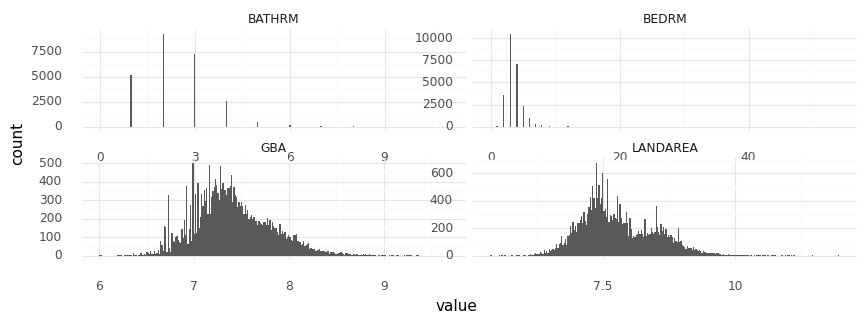

<ggplot: (8791477993009)>

In [36]:
# Look at training data features
train_y = train['LN_PRICE']
train_x = train[['BATHRM', 'BEDRM', 'GBA', 'LANDAREA']]

# Fix scales of GBA and Land Area
train_x['GBA'] = np.log(train_x['GBA'])
train_x['LANDAREA'] = np.log(train_x['LANDAREA'])

# View each feature distribution
(
    ggplot(train_x.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
) 

From this, we can see that some scaling will need to be done, but this will happen in the preprocessing section of the Pipeline.

## Modeling Pipeline

In [38]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','BEDRM', 'GBA', 'LANDAREA'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'BEDRM',
                                                                          'GBA',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                        

In [39]:
search.best_score_ # Mean out-of-sample error

-0.41977230763399137

In [40]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

## Test Performance

In [43]:
# Clean test data
test = test.dropna()

test_y = test['LN_PRICE']
test_x = test[['BATHRM', 'BEDRM', 'GBA', 'LANDAREA']]

# Fix scales of GBA and Land Area
test_x['GBA'] = np.log(test_x['GBA'])
test_x['LANDAREA'] = np.log(test_x['LANDAREA'])

In [44]:
# Use predict() method to get the best model
pred_y = search.predict(test_x)
m.mean_squared_error(test_y, pred_y)

0.3982886586757687

In [45]:
# R-squared
m.r2_score(test_y, pred_y)

0.34276347631834214

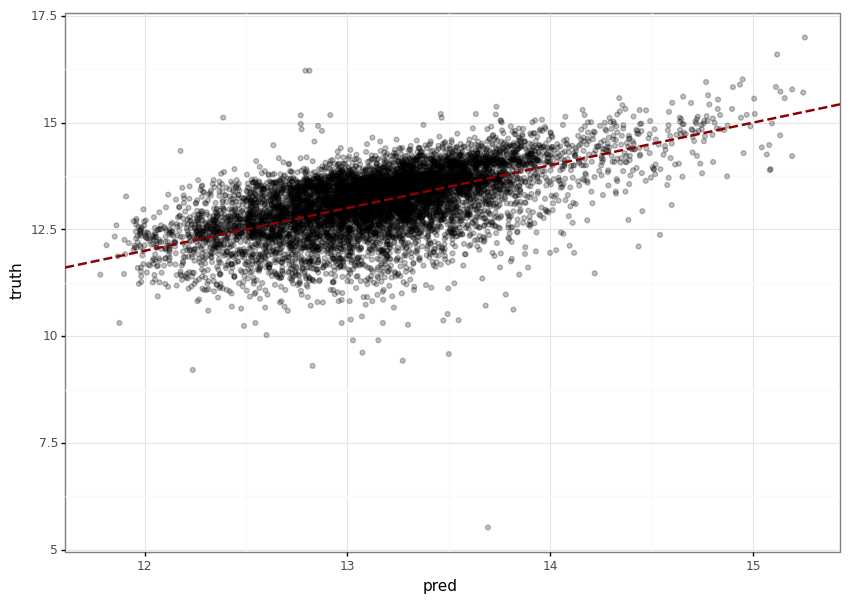

<ggplot: (8791477966044)>

In [46]:
# Plot performance 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.25) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

The model that best fit the data is going to be K-Nearest Neighbors with 30 neighbors. As we can see from above, the results from this model are better than that of the the example from class. The MSE went down from 0.51 to 0.40, and the R-squared went up from 0.25 to 0.34.